<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/D2l_4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Classfication Dataset - MNIST dataset

*   torch.nn.functional : 딥러닝에 자주 사용되는 수학적 함수
*   transform : 데이터의 여러 형태 지정 가능



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current cuda device is', device)

Current cuda device is cuda


파라미터 설정

In [ ]:
batch_size = 50 # 전체 데이터 개수 / batch_size = batch 개수
learning_rate = 0.0001
epoch_num = 15

MNIST 데이터 불러오기

In [ ]:
train_data = datasets.MNIST(root = './data/02/',
                            train = True,
                            download = True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                           train = False,
                           download = True,
                           transform = transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 138767026.40it/s]


Extracting ./data/02/MNIST/raw/train-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44049343.21it/s]


Extracting ./data/02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43066321.66it/s]

Extracting ./data/02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/02/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22074772.62it/s]


Extracting ./data/02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/02/MNIST/raw

number of training data :  60000
number of test data :  10000


데이터 확인

* squeeze() : 차원이 1인 차원을 제거해줌
    * pytorch에서 불러온 MNIST 데이터의 경우 [1,28,28]로 구성됨
    * 따라서 1을 없애야 이미지 그릴 수 있음

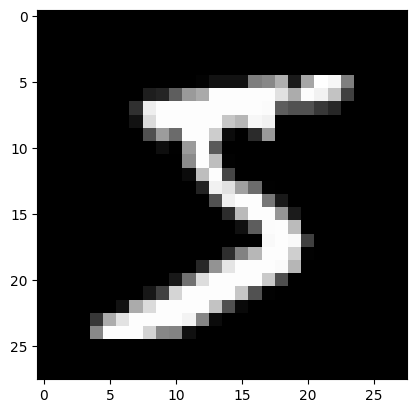

In [ ]:
img, label = train_data[0]
plt.imshow(img.squeeze().numpy(), cmap = 'gray')
plt.show()

미니 배치 구성
* torch.utils.data.DataLoader
    * 배치 사이즈로 구성
    * shuffle 하는 이유 : 데이터의 순서 학습하는 것 방지

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = batch_size,
                                           shuffle = True)
first_batch = train_loader.__iter__().__next__()

배치 확인

In [ ]:
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


모델 구성
* CNN 텐서 사이즈 계산
    * O = (I - K + 2P)/S + 1
    * O : output image size
    * I : input image size
    * K : kernel size
    * S : stride
    * P : padding size
* Padding
    * valid padding : 패딩을 추가하지 않은 형태
        * 항상 입력 사이즈보다 작게 됨
    * full padding : 입력 데이터의 모든 원소가 합성곱 연산에 동일한 비율로 참여하도록 함
        * 패딩의 폭 P = K - 1
    * same padding : 출력 크기를 입력크기와 동일하게 유지
        * 패딩의 폭 P = (K - 1) / 2

In [ ]:
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        # batch_size = 50, MNIST 데이터는 28 x 28 resolution
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 'same') # nn.Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 'same')
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(3136, 1000) # 7*7*64 = 3136
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x) :
        # 1번 레이어 : 합성곱층
        x = self.conv1(x)
        # [50, 1, 28, 28] -> [50, 32, 28, 28]

        x = F.relu(x)
        # [50, 32, 28, 28] -> [50, 32, 28, 28]

        x = F.max_pool2d(x, 2)
        # [50, 32, 28, 28] -> [50, 32, 14, 14], max_pool을 하면 지정한 사이즈만큼 줄어듦

        # 2번 레이어 : 합성곱층
        x = self.conv2(x)
        # [50, 32, 14, 14] -> [50, 64, 14, 14]

        x = F.relu(x)
        # [50, 64, 14, 14] -> [50, 64, 14, 14]

        x = F.max_pool2d(x, 2)
        # [50, 64, 14, 14] -> [50, 64, 7, 7]

        # 3번 레이어 : 전결합층
        x = self.dropout(x)
        # [50, 64, 7, 7] -> [50, 64, 7, 7]

        x = torch.flatten(x ,1)
        # [50, 64, 7, 7] -> [50, 3136], 여기서 flatten 하면서 64 * 7 * 7 = 3136됨!

        x = self.fc1(x)
        # [50, 3136] -> [50, 1000]

        x = F.relu(x)
        # [50, 3136] -> [50, 1000]

        x = self.fc2(x)
        # [50, 1000] -> [50, 10]

        output = F.log_softmax(x, dim = 1)
        # [50, 10] -> [50, 10]

        return output

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

모델 학습

In [ ]:
model.train()
i = 1
for epoch in range(epoch_num) :
    for data, target in train_loader :
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
        i += 1

Train Step : 1000	Loss : 0.145738
Train Step : 2000	Loss : 0.060328
Train Step : 3000	Loss : 0.014166
Train Step : 4000	Loss : 0.100173
Train Step : 5000	Loss : 0.011539
Train Step : 6000	Loss : 0.073358
Train Step : 7000	Loss : 0.058211
Train Step : 8000	Loss : 0.010091
Train Step : 9000	Loss : 0.022728
Train Step : 10000	Loss : 0.061178
Train Step : 11000	Loss : 0.015414
Train Step : 12000	Loss : 0.004768
Train Step : 13000	Loss : 0.004097
Train Step : 14000	Loss : 0.003642
Train Step : 15000	Loss : 0.033497
Train Step : 16000	Loss : 0.049911
Train Step : 17000	Loss : 0.062489
Train Step : 18000	Loss : 0.000712


모델 평가

In [ ]:
model.eval() # 평가시에는 dropout이 off 됨
correct = 0
for data, target in test_loader :
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy : 99.16%


### Image Classification Dataset - CIFAR10 dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력은 [0,1] 범위를 가지는 PILImage이므로 [-1,1]의 범위로 정규화된 Tensor로 변환해주기

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root = './data',
                                        train = True,
                                        download = True,
                                        transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root = './data',
                                       train = False,
                                       download = True,
                                       transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49091523.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


학습용 이미지 보기

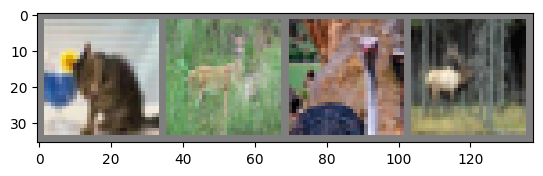

cat   deer  bird  deer 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img) :
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 학습용 이미지를 무작위로 가져옴
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답 label 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

합성곱 신경망 모델 정의 (CNN)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module) :
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원 평탄화
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

손실 함수와 Optimizer 정의

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

신경망 학습

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # gradient 매개변수를 0으로 만듦
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999 : # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.180
[1,  4000] loss: 1.850
[1,  6000] loss: 1.668
[1,  8000] loss: 1.566
[1, 10000] loss: 1.504
[1, 12000] loss: 1.455
[2,  2000] loss: 1.394
[2,  4000] loss: 1.347
[2,  6000] loss: 1.339
[2,  8000] loss: 1.321
[2, 10000] loss: 1.287
[2, 12000] loss: 1.268
Finished Training


학습한 모델 저장

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

시험용 데이터로 테스트
* 시험용 데이터 확인
* 저장한 모델 불러오기

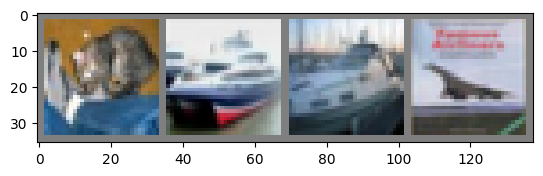

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# 저장한 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [ ]:
# 전체 데이터셋에 대한 성능 분석
correct = 0
total = 0

with torch.no_grad() :
    for data in testloader :
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# 각 클래스 별로 정확도 확인
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # 각 분류별 올바른 예측 수 합계
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# 각 분류별 정확도 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.2 %
Accuracy for class: car   is 65.1 %
Accuracy for class: bird  is 30.7 %
Accuracy for class: cat   is 41.5 %
Accuracy for class: deer  is 57.9 %
Accuracy for class: dog   is 44.8 %
Accuracy for class: frog  is 66.3 %
Accuracy for class: horse is 58.7 %
Accuracy for class: ship  is 76.0 %
Accuracy for class: truck is 69.6 %


### Softmax Regression - 1
* 로지스틱 회귀: 둘 중 하나를 선택하는 이진 분류
* 소프트맥스 회귀 : 여러 개의 선택지 중 하나를 선택하는 다중 분류

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) # 랜덤 시드 고정

훈련 데이터 샘플 정의
* x_train : 8 x 4 Tensor
    * 8개의 샘플이 있고 각각 4개의 feature 존재
* y_train : 클래스는 총 3개로 0, 1, 2의 값 가짐

In [ ]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]

In [ ]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [ ]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


클래스 원핫 인코딩

In [ ]:
y_one_hot = torch.zeros(8,3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


모델 및 optimizer 정의

In [ ]:
model = nn.Linear(4, 3)

optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# 모델 파라미터 확인, tensor 두개는 각각 가중치와 편향을 의미함
print('#1')
print(list(model.parameters()))

#1
[Parameter containing:
tensor([[ 0.2576, -0.2207, -0.0969,  0.2347],
        [-0.4707,  0.2999, -0.1029,  0.2544],
        [ 0.0695, -0.0612,  0.1387,  0.0247]], requires_grad=True), Parameter containing:
tensor([ 0.1826, -0.1949, -0.0365], requires_grad=True)]


epoch 설정 및 학습


In [ ]:
# epoch = 1000
nb_epochs = 1000
for epoch in range(nb_epochs + 1) :
    # H(x) 계산
    prediction = model(x_train)
    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost 함수 미분 및 가중치 업데이트, cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0 :
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/1000 Cost: 1.616785
Epoch  100/1000 Cost: 0.658891
Epoch  200/1000 Cost: 0.573443
Epoch  300/1000 Cost: 0.518151
Epoch  400/1000 Cost: 0.473265
Epoch  500/1000 Cost: 0.433516
Epoch  600/1000 Cost: 0.396563
Epoch  700/1000 Cost: 0.360914
Epoch  800/1000 Cost: 0.325392
Epoch  900/1000 Cost: 0.289178
Epoch 1000/1000 Cost: 0.254148
